In [1]:
%pylab inline
import numpy as np
from tqdm import tqdm
from sklearn.feature_selection import mutual_info_regression

import sys
sys.path.append('/home/samuel/Dropbox/Nek5000/Airfoil/Fine_data_POD/Linear regression')
sys.path.append('/Users/samuelrudy/Dropbox/Nek5000/Airfoil/Fine_data_POD/Linear regression')
from guth import *

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

Populating the interactive namespace from numpy and matplotlib


In [2]:
@nb.njit
def conv_smoother(x,K):
    
    y = np.zeros_like(x)
    m = len(x)
    L = len(K)
    L2 = int(floor(L/2))
    
    for i in range(m):
        k0 = i-L2
        s = 0
        for j in range(L):
            if k0+j < 0 or k0+j>=m:
                pass
            else:
                y[i] = y[i] + x[k0+j]*K[j]
                s = s + K[j]
        y[i] = y[i] / s
        
    return y

def smooth(x):
    
    # Gaussian smoother
    width_smoother = int(100)
    scale_smoother = int(10)
        
    # Exp decay smoother (only uses history)
    smoother_kern = np.zeros(width_smoother)
    for i in range(int(width_smoother/2)):
        smoother_kern[int(width_smoother/2) - i] = np.exp(-i/scale_smoother)    
            
    smoother_kern = smoother_kern/np.sum(smoother_kern)
    xs = conv_smoother(x, smoother_kern)
    
    return xs

In [3]:
# Load time series from each of F_{p,\xi,\psi} and H_{p,\xi,\psi}
m_test = 15000
t = (1020-0.01*np.arange(m_test))[::-1]
Taus = [np.round(0.7*j,1) for j in range(16)]

F_p_Results = {}
F_psi_Results = {}
F_xi_Results = {}

H_p_path = '../P_LSTM_ROM/saved_models/'
H_p_Results = np.load(H_p_path+'P_ROM_results.npy',allow_pickle=True).item()

H_psi_path = '../POD/Psi_LSTM_ROM/saved_models/'
H_psi_Results = np.load(H_psi_path+'Psi_ROM_results.npy',allow_pickle=True).item()

H_xi_path = '../FFNN/Xi_LSTM_ROM/saved_models/'
H_xi_Results = np.load(H_xi_path+'Xi_ROM_32_results.npy',allow_pickle=True).item()

for tau in Taus:
    
    # Load Xi to q results
    base_path = '../P_to_q/saved_results/'
    file = base_path+'results_tau'+str(tau)+'.npy'
    F_p_Results[tau] = np.load(file,allow_pickle=True).item()
    F_p_Results[tau]['true'] = F_p_Results[tau]['true'][-m_test:]
    F_p_Results[tau]['NN'] = F_p_Results[tau]['NN'][-m_test:]
    
    # Load Xi to q results
    base_path = '../POD/Psi_to_q/saved_models/'
    file = base_path+'results_tau'+str(tau)+'.npy'
    F_psi_Results[tau] = np.load(file,allow_pickle=True).item()
    F_psi_Results[tau]['true'] = F_psi_Results[tau]['true'][-m_test:]
    F_psi_Results[tau]['NN'] = F_psi_Results[tau]['NN'][-m_test:]
    
    # Load Xi to q results
    base_path = '../FFNN/Xi_to_q/saved_models/'
    file = base_path+'results_tau'+str(tau)+'.npy'
    F_xi_Results[tau] = np.load(file,allow_pickle=True).item()
    F_xi_Results[tau]['true'] = F_xi_Results[tau]['true'][-m_test:]
    F_xi_Results[tau]['NN'] = F_xi_Results[tau]['NN'][-m_test:]
    
    H_p_Results[tau]['NN'] = smooth(H_p_Results[tau]['NN'])[-m_test:]
    H_p_Results[tau]['true'] = H_p_Results[tau]['true'][-m_test:]
    
    H_psi_Results[tau]['NN'] = smooth(H_psi_Results[tau]['NN'])[-m_test:]
    H_psi_Results[tau]['true'] = H_psi_Results[tau]['true'][-m_test:]
    
    H_xi_Results[tau]['NN'] = smooth(H_xi_Results[tau]['NN'])[-m_test:]
    H_xi_Results[tau]['true'] = H_xi_Results[tau]['true'][-m_test:]

In [4]:
all_results = [F_p_Results, F_psi_Results, F_xi_Results, \
               H_p_Results, H_psi_Results, H_xi_Results]

labels = [r'$F_p$', r'$F_\psi$', r'$F_\xi$', r'$H_p$', r'$H_\psi$', r'$H_\xi$']

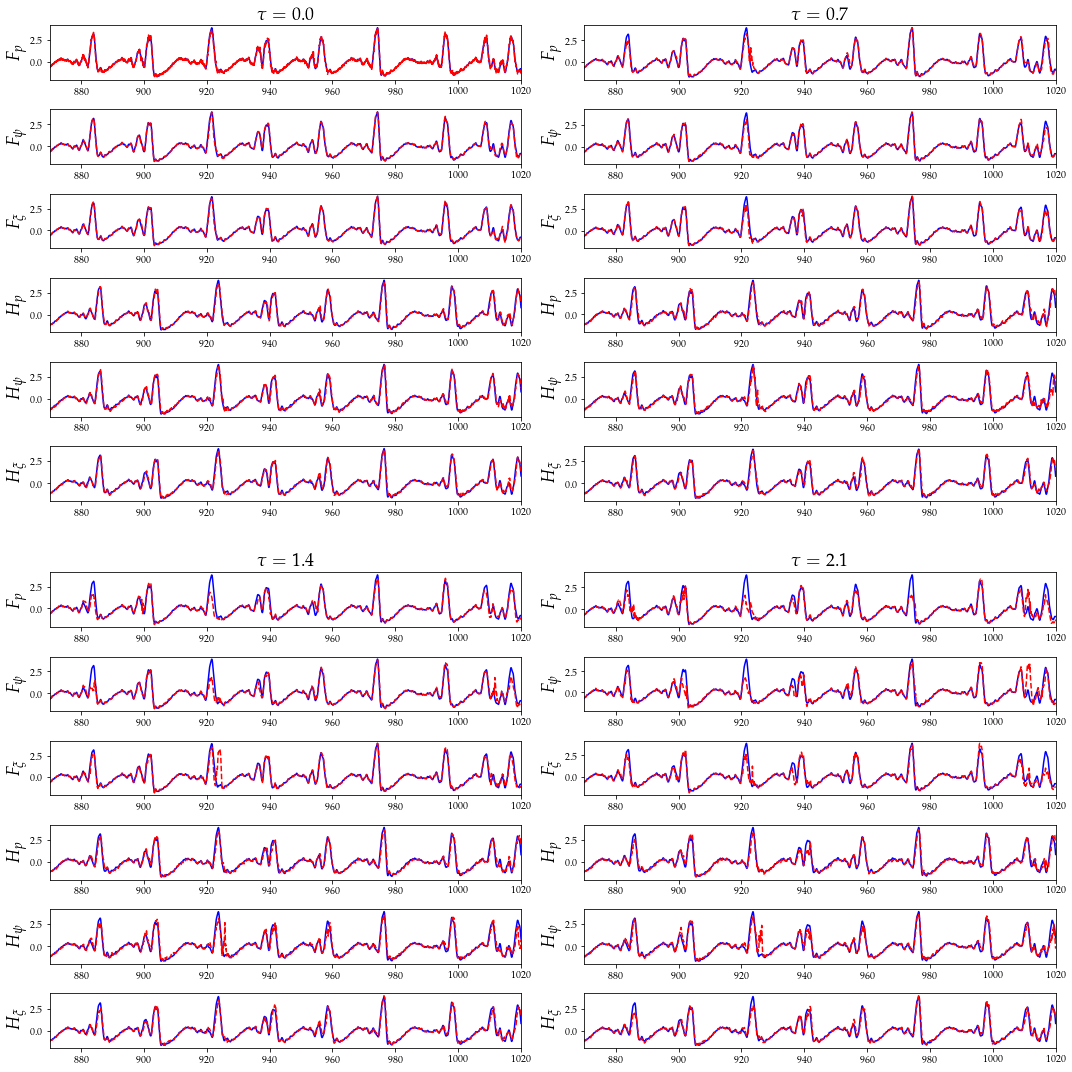

In [5]:
figure(figsize = (15,15))
label_fs = 18

plot_taus = [0.0, 0.7, 1.4, 2.1]

subfig_height = 2
gap = 1

for j in range(6):
    
    tau = plot_taus[0]
    subplot2grid((12*subfig_height+gap,2),(j*subfig_height,0), rowspan=subfig_height, colspan=1)
    plot(t,all_results[j][tau]['true'], 'b')
    plot(t,all_results[j][tau]['NN'], 'r--')
    xlim([t[0],t[-1]])
    ylabel(labels[j],fontsize = label_fs)
    if j==0: title(r'$\tau='+str(tau)+'$',fontsize = label_fs)
        
    tau = plot_taus[1]
    subplot2grid((12*subfig_height+gap,2),(j*subfig_height,1), rowspan=subfig_height, colspan=1)
    plot(t,all_results[j][tau]['true'], 'b')
    plot(t,all_results[j][tau]['NN'], 'r--')
    xlim([t[0],t[-1]])
    ylabel(labels[j],fontsize = label_fs)
    if j==0: title(r'$\tau='+str(tau)+'$',fontsize = label_fs)
    
    tau = plot_taus[2]
    subplot2grid((12*subfig_height+gap,2),((j+6)*subfig_height+gap,0), 
                 rowspan=subfig_height, colspan=1)
    plot(t,all_results[j][tau]['true'], 'b')
    plot(t,all_results[j][tau]['NN'], 'r--')
    xlim([t[0],t[-1]])
    ylabel(labels[j],fontsize = label_fs)
    if j==0: title(r'$\tau='+str(tau)+'$',fontsize = label_fs)
    
    tau = plot_taus[3]
    subplot2grid((12*subfig_height+gap,2),((j+6)*subfig_height+gap,1), 
                 rowspan=subfig_height, colspan=1)
    plot(t,all_results[j][tau]['true'], 'b')
    plot(t,all_results[j][tau]['NN'], 'r--')
    xlim([t[0],t[-1]])
    ylabel(labels[j],fontsize = label_fs)
    if j==0: title(r'$\tau='+str(tau)+'$',fontsize = label_fs)
    
tight_layout()

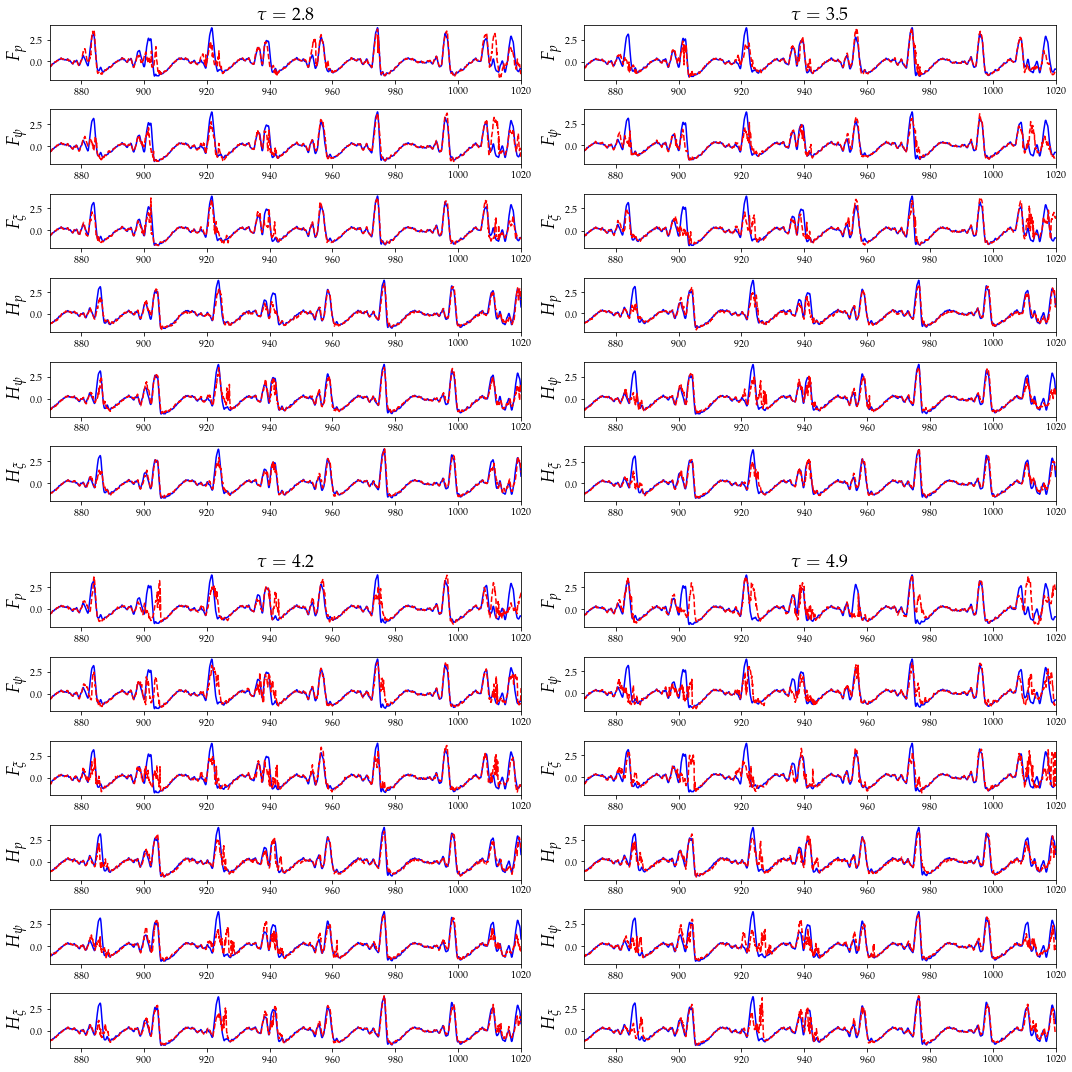

In [6]:
figure(figsize = (15,15))
label_fs = 18

plot_taus = [2.8, 3.5, 4.2, 4.9]

subfig_height = 2
gap = 1

for j in range(6):
    
    tau = plot_taus[0]
    subplot2grid((12*subfig_height+gap,2),(j*subfig_height,0), rowspan=subfig_height, colspan=1)
    plot(t,all_results[j][tau]['true'], 'b')
    plot(t,all_results[j][tau]['NN'], 'r--')
    xlim([t[0],t[-1]])
    ylabel(labels[j],fontsize = label_fs)
    if j==0: title(r'$\tau='+str(tau)+'$',fontsize = label_fs)
        
    tau = plot_taus[1]
    subplot2grid((12*subfig_height+gap,2),(j*subfig_height,1), rowspan=subfig_height, colspan=1)
    plot(t,all_results[j][tau]['true'], 'b')
    plot(t,all_results[j][tau]['NN'], 'r--')
    xlim([t[0],t[-1]])
    ylabel(labels[j],fontsize = label_fs)
    if j==0: title(r'$\tau='+str(tau)+'$',fontsize = label_fs)
    
    tau = plot_taus[2]
    subplot2grid((12*subfig_height+gap,2),((j+6)*subfig_height+gap,0), 
                 rowspan=subfig_height, colspan=1)
    plot(t,all_results[j][tau]['true'], 'b')
    plot(t,all_results[j][tau]['NN'], 'r--')
    xlim([t[0],t[-1]])
    ylabel(labels[j],fontsize = label_fs)
    if j==0: title(r'$\tau='+str(tau)+'$',fontsize = label_fs)
    
    tau = plot_taus[3]
    subplot2grid((12*subfig_height+gap,2),((j+6)*subfig_height+gap,1), 
                 rowspan=subfig_height, colspan=1)
    plot(t,all_results[j][tau]['true'], 'b')
    plot(t,all_results[j][tau]['NN'], 'r--')
    xlim([t[0],t[-1]])
    ylabel(labels[j],fontsize = label_fs)
    if j==0: title(r'$\tau='+str(tau)+'$',fontsize = label_fs)
    
tight_layout()

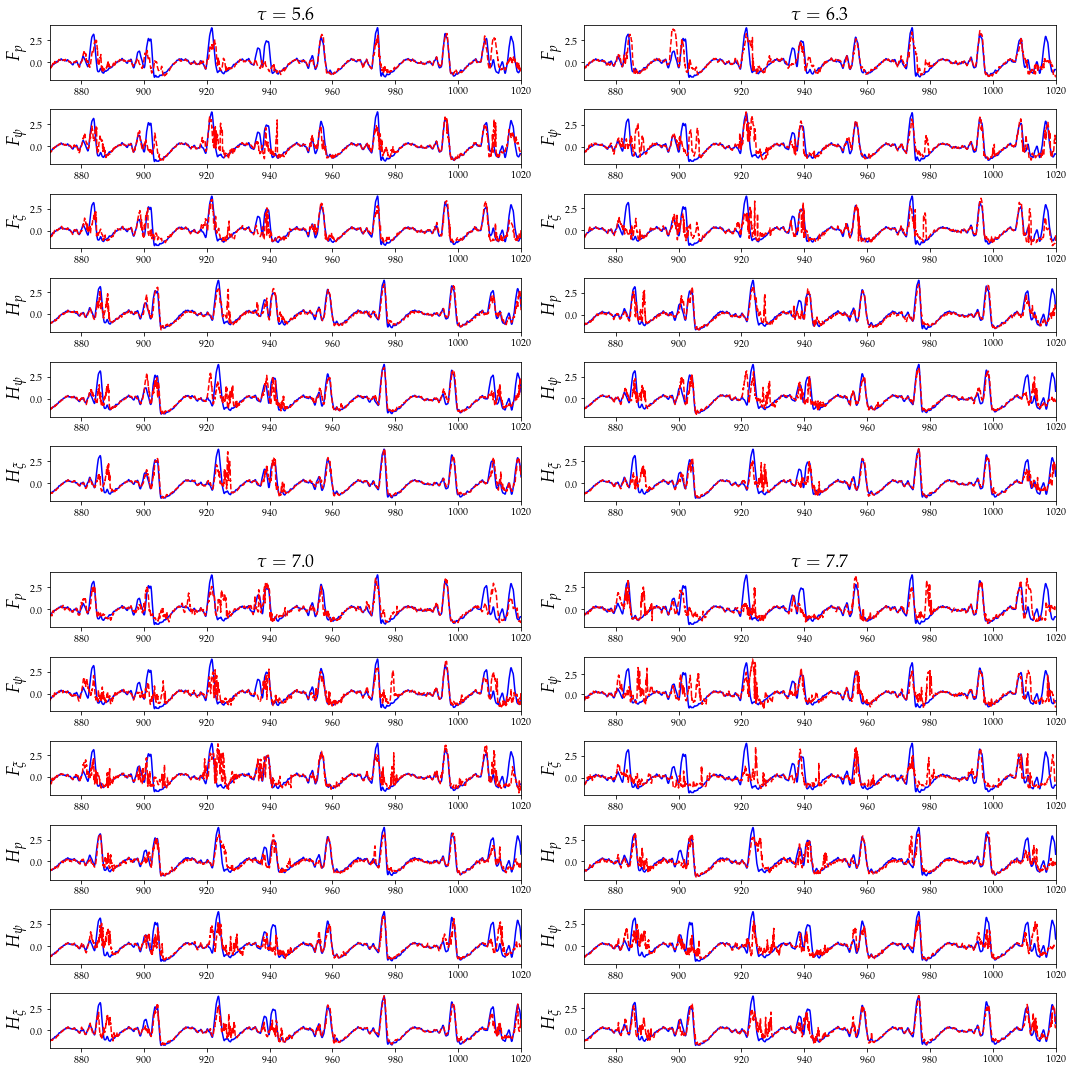

In [7]:
figure(figsize = (15,15))
label_fs = 18

plot_taus = [5.6, 6.3, 7.0, 7.7]

subfig_height = 2
gap = 1

for j in range(6):
    
    tau = plot_taus[0]
    subplot2grid((12*subfig_height+gap,2),(j*subfig_height,0), rowspan=subfig_height, colspan=1)
    plot(t,all_results[j][tau]['true'], 'b')
    plot(t,all_results[j][tau]['NN'], 'r--')
    xlim([t[0],t[-1]])
    ylabel(labels[j],fontsize = label_fs)
    if j==0: title(r'$\tau='+str(tau)+'$',fontsize = label_fs)
        
    tau = plot_taus[1]
    subplot2grid((12*subfig_height+gap,2),(j*subfig_height,1), rowspan=subfig_height, colspan=1)
    plot(t,all_results[j][tau]['true'], 'b')
    plot(t,all_results[j][tau]['NN'], 'r--')
    xlim([t[0],t[-1]])
    ylabel(labels[j],fontsize = label_fs)
    if j==0: title(r'$\tau='+str(tau)+'$',fontsize = label_fs)
    
    tau = plot_taus[2]
    subplot2grid((12*subfig_height+gap,2),((j+6)*subfig_height+gap,0), 
                 rowspan=subfig_height, colspan=1)
    plot(t,all_results[j][tau]['true'], 'b')
    plot(t,all_results[j][tau]['NN'], 'r--')
    xlim([t[0],t[-1]])
    ylabel(labels[j],fontsize = label_fs)
    if j==0: title(r'$\tau='+str(tau)+'$',fontsize = label_fs)
    
    tau = plot_taus[3]
    subplot2grid((12*subfig_height+gap,2),((j+6)*subfig_height+gap,1), 
                 rowspan=subfig_height, colspan=1)
    plot(t,all_results[j][tau]['true'], 'b')
    plot(t,all_results[j][tau]['NN'], 'r--')
    xlim([t[0],t[-1]])
    ylabel(labels[j],fontsize = label_fs)
    if j==0: title(r'$\tau='+str(tau)+'$',fontsize = label_fs)
    
tight_layout()

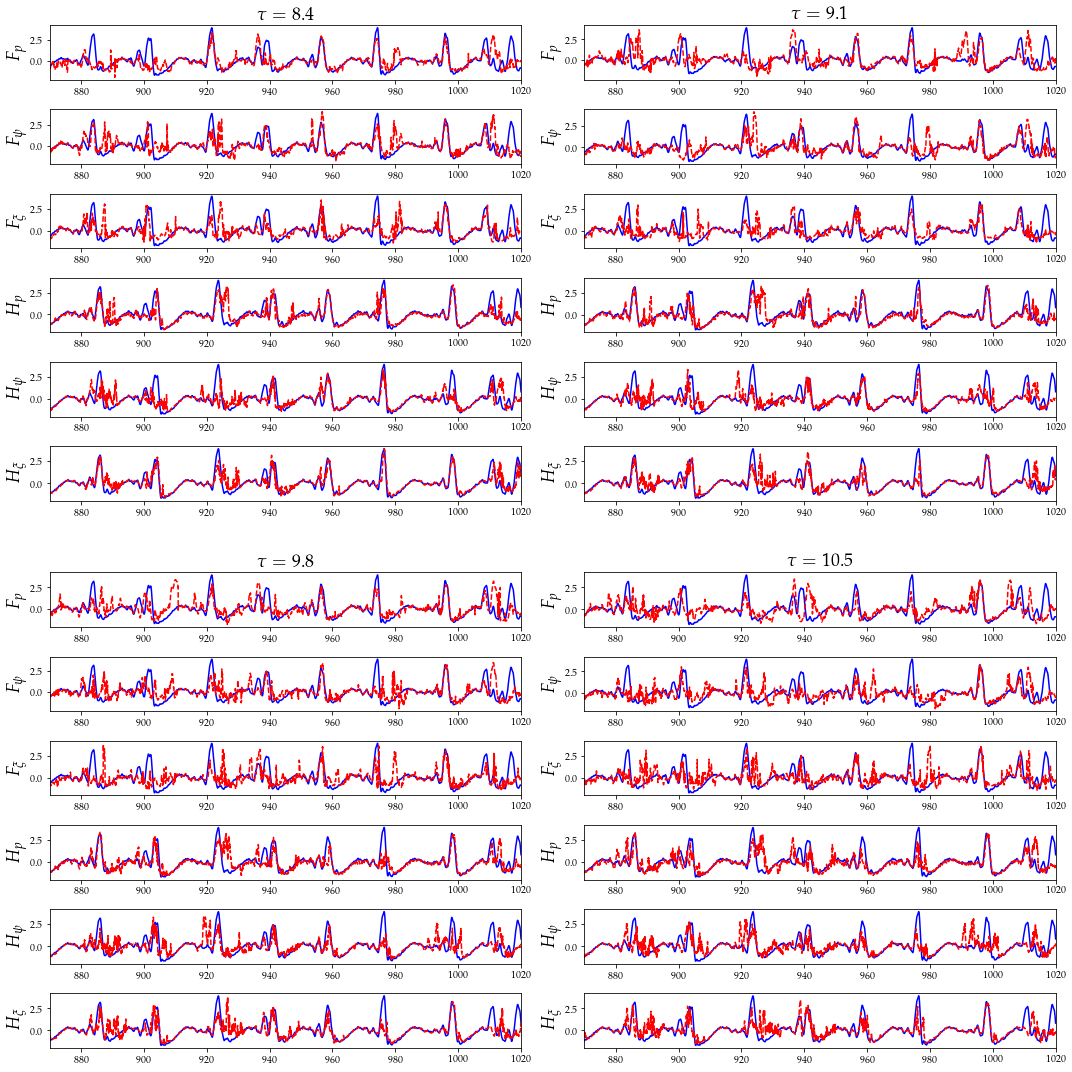

In [8]:
figure(figsize = (15,15))
label_fs = 18

plot_taus = [8.4, 9.1, 9.8, 10.5]

subfig_height = 2
gap = 1

for j in range(6):
    
    tau = plot_taus[0]
    subplot2grid((12*subfig_height+gap,2),(j*subfig_height,0), rowspan=subfig_height, colspan=1)
    plot(t,all_results[j][tau]['true'], 'b')
    plot(t,all_results[j][tau]['NN'], 'r--')
    xlim([t[0],t[-1]])
    ylabel(labels[j],fontsize = label_fs)
    if j==0: title(r'$\tau='+str(tau)+'$',fontsize = label_fs)
        
    tau = plot_taus[1]
    subplot2grid((12*subfig_height+gap,2),(j*subfig_height,1), rowspan=subfig_height, colspan=1)
    plot(t,all_results[j][tau]['true'], 'b')
    plot(t,all_results[j][tau]['NN'], 'r--')
    xlim([t[0],t[-1]])
    ylabel(labels[j],fontsize = label_fs)
    if j==0: title(r'$\tau='+str(tau)+'$',fontsize = label_fs)
    
    tau = plot_taus[2]
    subplot2grid((12*subfig_height+gap,2),((j+6)*subfig_height+gap,0), 
                 rowspan=subfig_height, colspan=1)
    plot(t,all_results[j][tau]['true'], 'b')
    plot(t,all_results[j][tau]['NN'], 'r--')
    xlim([t[0],t[-1]])
    ylabel(labels[j],fontsize = label_fs)
    if j==0: title(r'$\tau='+str(tau)+'$',fontsize = label_fs)
    
    tau = plot_taus[3]
    subplot2grid((12*subfig_height+gap,2),((j+6)*subfig_height+gap,1), 
                 rowspan=subfig_height, colspan=1)
    plot(t,all_results[j][tau]['true'], 'b')
    plot(t,all_results[j][tau]['NN'], 'r--')
    xlim([t[0],t[-1]])
    ylabel(labels[j],fontsize = label_fs)
    if j==0: title(r'$\tau='+str(tau)+'$',fontsize = label_fs)
    
tight_layout()

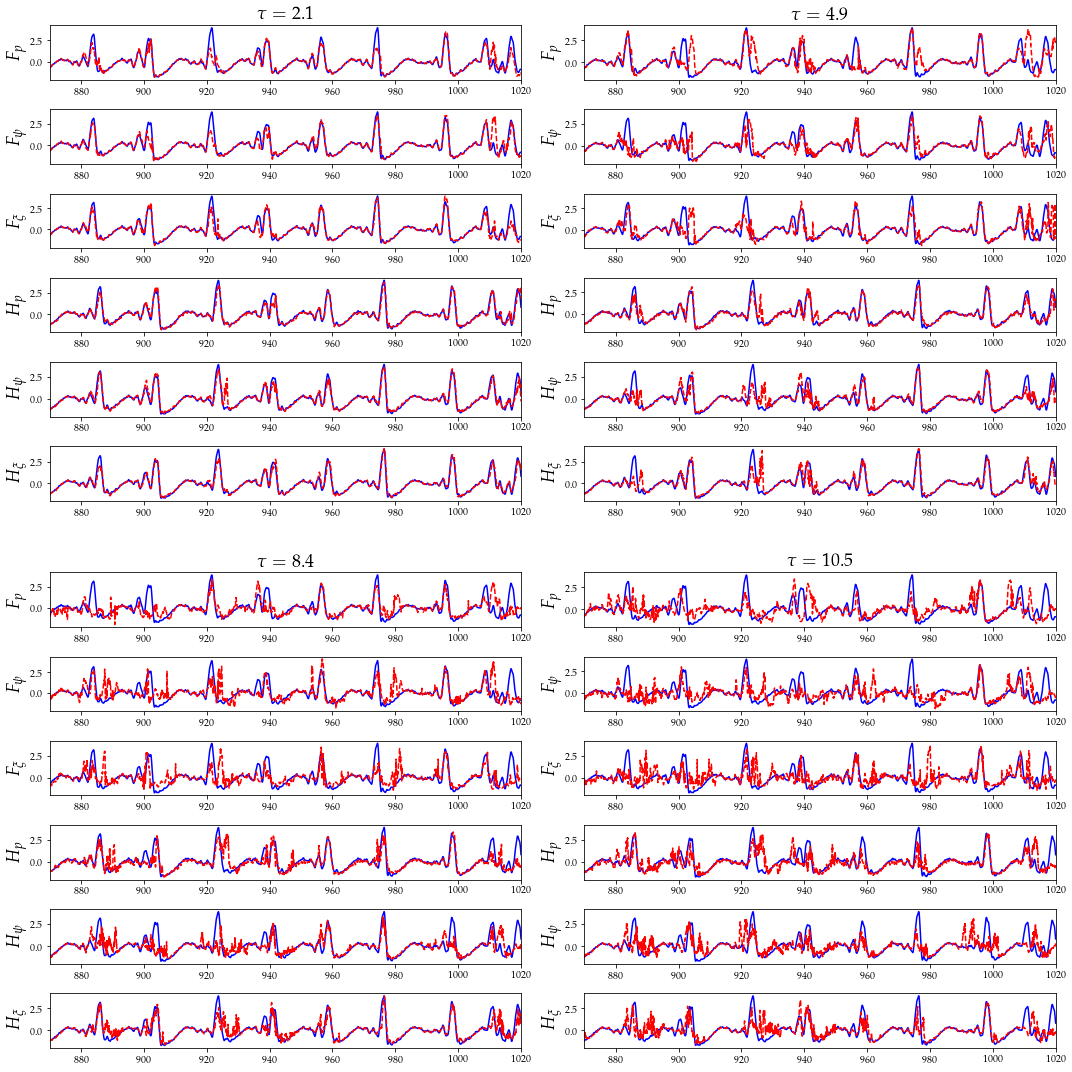

In [9]:
figure(figsize = (15,15))
label_fs = 18

plot_taus = [2.1, 4.9, 8.4, 10.5]

subfig_height = 2
gap = 1

for j in range(6):
    
    tau = plot_taus[0]
    subplot2grid((12*subfig_height+gap,2),(j*subfig_height,0), rowspan=subfig_height, colspan=1)
    plot(t,all_results[j][tau]['true'], 'b')
    plot(t,all_results[j][tau]['NN'], 'r--')
    xlim([t[0],t[-1]])
    ylabel(labels[j],fontsize = label_fs)
    if j==0: title(r'$\tau='+str(tau)+'$',fontsize = label_fs)
        
    tau = plot_taus[1]
    subplot2grid((12*subfig_height+gap,2),(j*subfig_height,1), rowspan=subfig_height, colspan=1)
    plot(t,all_results[j][tau]['true'], 'b')
    plot(t,all_results[j][tau]['NN'], 'r--')
    xlim([t[0],t[-1]])
    ylabel(labels[j],fontsize = label_fs)
    if j==0: title(r'$\tau='+str(tau)+'$',fontsize = label_fs)
    
    tau = plot_taus[2]
    subplot2grid((12*subfig_height+gap,2),((j+6)*subfig_height+gap,0), 
                 rowspan=subfig_height, colspan=1)
    plot(t,all_results[j][tau]['true'], 'b')
    plot(t,all_results[j][tau]['NN'], 'r--')
    xlim([t[0],t[-1]])
    ylabel(labels[j],fontsize = label_fs)
    if j==0: title(r'$\tau='+str(tau)+'$',fontsize = label_fs)
    
    tau = plot_taus[3]
    subplot2grid((12*subfig_height+gap,2),((j+6)*subfig_height+gap,1), 
                 rowspan=subfig_height, colspan=1)
    plot(t,all_results[j][tau]['true'], 'b')
    plot(t,all_results[j][tau]['NN'], 'r--')
    xlim([t[0],t[-1]])
    ylabel(labels[j],fontsize = label_fs)
    if j==0: title(r'$\tau='+str(tau)+'$',fontsize = label_fs)
    
tight_layout()